In [1]:
%config Completer.use_jedi = False
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import img_to_array 



Loading the Dataset

In [2]:
train_dir = '../input/covidistesgp/CovidDataset/train'
test_dir = '../input/covidistesgp/CovidDataset/validation'

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir)
classes = data.class_names
print(classes)

Found 2000 files belonging to 2 classes.
['covid', 'healthy']


Plotting the Images

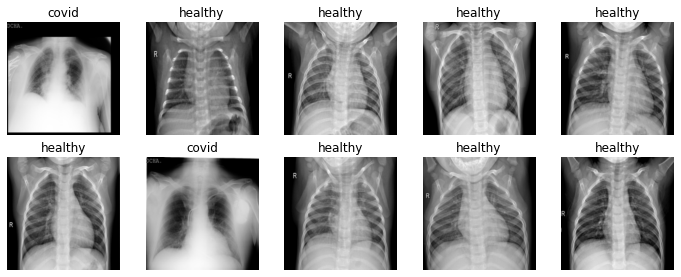

In [4]:
plt.figure(figsize = (12,12))
for image, label in data.take(1):
    for i in range(10):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(classes[label[i]])
        plt.axis("off")

# Image Data Generator Class

In [5]:
image_size = (299,299)
batch_size = 32

In [6]:
aug_train_datagen = ImageDataGenerator(
        rescale = 1.0/255,
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2],# brightness
        validation_split = 0.1) 
test_datagen = ImageDataGenerator(rescale = 1.0/255)

In [7]:
aug_train_gen = aug_train_datagen.flow_from_directory(
                  train_dir,
                  target_size=image_size, # resize to this size
                  shuffle=True,
                  batch_size=batch_size, # number of images to extract from folder for every batch
                  class_mode="binary", # classes to predict
                  subset="training",
                  seed=2020 # to make the result reproducible
                  )

Found 1800 images belonging to 2 classes.


In [8]:
aug_valid_gen = aug_train_datagen.flow_from_directory(
                  train_dir,
                  target_size=image_size, # resize to this size
                  shuffle=True,
                  batch_size=batch_size, # number of images to extract from folder for every batch
                  class_mode="binary", # classes to predict
                  subset="validation",
                  seed=2020 # to make the result reproducible
                  )

Found 200 images belonging to 2 classes.


In [9]:
test_gen = test_datagen.flow_from_directory(
                  test_dir,
                  target_size=image_size, # resize to this size
                  shuffle=False,
                  batch_size=batch_size, # number of images to extract from folder for every batch
                  class_mode="binary", # classes to predict
                  seed=2020 # to make the result reproducible
                  )

Found 200 images belonging to 2 classes.


# Transfer Learning

In [10]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape= (299,299,3),
)

87916544/87910968 [==============================] - 1s 0us/step


### Freezing the base layer

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D

model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(120, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 121       
Total params: 22,048,785
Trainable params: 22,014,353
Non-trainable params: 34,432
_______________________________________

In [12]:
base_model.trainable = False

In [13]:
from keras.optimizers import Adam
optimizer = Adam(lr = 0.001)
loss = 'binary_crossentropy'
model.compile(optimizer= optimizer, 
             loss = loss, 
             metrics = tf.keras.metrics.AUC())

In [14]:
hist = model.fit(aug_train_gen,
                epochs = 5,
                validation_data = aug_valid_gen)

Epoch 1/5
57/57 [==============================] - 62s 965ms/step - loss: 0.4820 - auc: 0.8132 - val_loss: 0.1582 - val_auc: 0.9851
Epoch 2/5
57/57 [==============================] - 44s 779ms/step - loss: 0.2031 - auc: 0.9654 - val_loss: 0.1125 - val_auc: 0.9822
Epoch 3/5
57/57 [==============================] - 44s 777ms/step - loss: 0.1613 - auc: 0.9792 - val_loss: 0.1434 - val_auc: 0.9815
Epoch 4/5
57/57 [==============================] - 45s 784ms/step - loss: 0.1576 - auc: 0.9778 - val_loss: 0.1363 - val_auc: 0.9809
Epoch 5/5
57/57 [==============================] - 44s 778ms/step - loss: 0.1671 - auc: 0.9770 - val_loss: 0.1077 - val_auc: 0.9885


### Un-Freezing the Base Layer

In [15]:
for layer in model.layers[-13:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

In [16]:
optimizer = Adam(lr = 0.0001)
loss = 'binary_crossentropy'
model.compile(optimizer= optimizer, 
             loss = loss, 
             metrics = tf.keras.metrics.AUC())

In [17]:
hist = model.fit(aug_train_gen,
                epochs = 5,
                validation_data = aug_valid_gen)

Epoch 1/5
57/57 [==============================] - 58s 871ms/step - loss: 0.4306 - auc_1: 0.9478 - val_loss: 0.2154 - val_auc_1: 0.9660
Epoch 2/5
57/57 [==============================] - 48s 849ms/step - loss: 0.0982 - auc_1: 0.9902 - val_loss: 0.1628 - val_auc_1: 0.9887
Epoch 3/5
57/57 [==============================] - 48s 842ms/step - loss: 0.1039 - auc_1: 0.9920 - val_loss: 0.0844 - val_auc_1: 0.9887
Epoch 4/5
57/57 [==============================] - 49s 859ms/step - loss: 0.0645 - auc_1: 0.9965 - val_loss: 0.1104 - val_auc_1: 0.9879
Epoch 5/5
57/57 [==============================] - 48s 840ms/step - loss: 0.0937 - auc_1: 0.9938 - val_loss: 0.0614 - val_auc_1: 0.9889


In [18]:
test_loss, test_accuracy = model.evaluate(test_gen)
print('Test loss: {} Test Accuracy: {}'.format(test_loss, test_accuracy))

7/7 [==============================] - 2s 304ms/step - loss: 0.1768 - auc_1: 0.9765
Test loss: 0.17680315673351288 Test Accuracy: 0.9765499234199524
